PyTorch is a very popular machine learning library used to solved all kinds of problems, including regression and classification. In this article, we'll have a look at a typical workflow for a simple linear regression problem. To keep things simple, we'll stick to just the necessary elements, from importing the required libraries to saving and loading a trained model.

There are four major steps to follow during a machine learning process:

1) Data preparation <br>
2) Model building <br>
3) Model training <br>
4) Model evaluation <br>

Additionally, we'll save the working model, load it back in and test if it still works as expected.

And now, without further ado, let's jump right in and start at the first step.

## Data Preparation

We're going to need some stuff to work with, so, as usual, let's start with the imports:

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd

Let's check out the version of PyTorch:

In [ ]:
torch.__version__

'2.5.1+cu124'

### Parameters and Data Points

There are all kinds of data out there. Anything can be data: text, numbers, images, sounds, videos, and what have you. As our machines only understand numbers, all these kinds of data must be turned into numbers. To make it simpler, let's use numerical data from the very beginning. Our data is going to be 100 float numbers between 0 and 1 arranged linearly, so in such a way that a given change along the X axis always produces the same change along the Y axis.

This sounds like a typical linear function where y is calculated in the following manner:

$ \text{y} = \text{ax} + \text{b} $<br>

So, we have the x, we need the two parameters, a and b. Also, let's rename them weight and bias respectively, as this is the nomenclature used in machine learning. We're actually going to create a very simple neural network with one input, one output, one weight and one bias.

Normally, we don't know what the parameters are. The weights and biases are usually initialized with some random values. In our case, however, let's set them explicitly so that we can clearly see what's going on and how our prediction slowly approach the desired values.

Weights and biases are paraeters. Again, in ML nomenclature, parameters are things that can be learned by the model. This is exactly what we are going to do here. At first the model will use fully random values and then it will learn and change the values so that they get closer and closer to the original values we're just going to set.

And one more thing. We usually use capital letters for the features (X in this case) and small letters for the labels (y in this case). So, our formula can be rewritten as:

$ \text{y} = \text{weight} \times \text{X} + \text{bias} $<br>

And now, let's set the parameters and create the data points:

In [ ]:
# Let's set the parameters.
weight = 0.8
bias = 0.4

# Let's create the data points
start = 0
end = 1
step = 0.01

# We use unsqueeze to add a dimension of size 1.
X = torch.arange(start, end, step).unsqueeze(dim=1)

# Here's the formula for y.
y = weight * X + bias

# Let's view some initial values.
X[:5], y[:5]

(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.4000],
         [0.4080],
         [0.4160],
         [0.4240],
         [0.4320]]))

### Training Set and Test Set

Before we start building our model, we have to split the data into two or three sets. Most of the data will be used for training and we'll put it in the training set. But we want to keep some of the data apart so that the model never gets to see it. This way it will not influence the model during the training and we'll be able to see how well our model performs on data it has never seen. That's the whole point, after all. We don't want our model to perform well just on the training data, it should perform well on unknown data.

Sometimes we create one more set, validation set, with data used to validate the model before applying it to test data. We can use it to tune the model. This set is not always used, though, and for simplicity's sake, we're not going to create it either.

So, let's split our data into a training set (80% of the data) and a test set (the remaining 20% of the data):

In [ ]:
# Let's split the data into two sets.
split_level = int(0.8 * len(X))

# We'll have the following sets:
# X_train - training set with features
# y_train - training set with labels
# X_test - test set with features
# y_test - test set with labels
X_train, y_train = X[:split_level], y[:split_level]
X_test, y_test = X[split_level:], y[split_level:]

# Let's check the sizes of the sets.
len(X_train), len(y_train), len(X_test), len(y_test)

(80, 80, 20, 20)

Good, we have 80 data points for training and 10 data points for testing. But it would be awesome to visualize the data. Computers like numbers, humans like to see things.

### Data Visualization

Let's create a function to visualize the data because we'll be visualizing data a couple times. We'll pass the four sets to the function as well as predictions. For now we don't have any predictions, so we'll set it to None and plot them conditionally, only if they exist. A scatter plot seems like a good choice to visualize the data points as actual points. Here's the function:

In [6]:
# We pass the four sets and predictions to the function.
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and predictions if there are any.
  """
  plt.figure(figsize=(12, 6))

  # Plot training data.
  plt.scatter(train_data, train_labels, marker='o', c="darkblue", s=6, label="Training data")

  # Plot test data.
  plt.scatter(test_data, test_labels, marker='o', c="green", s=6, label="Test data")

  if predictions is not None:
    # Plot predictions.
    plt.scatter(test_data, predictions, marker='o', c="red", s=6, label="Predictions")

  # Show the legend.
  plt.legend(prop={"size": 15});

Let's call the function and see our data points. We can clearly tell the training data from the test data by color:

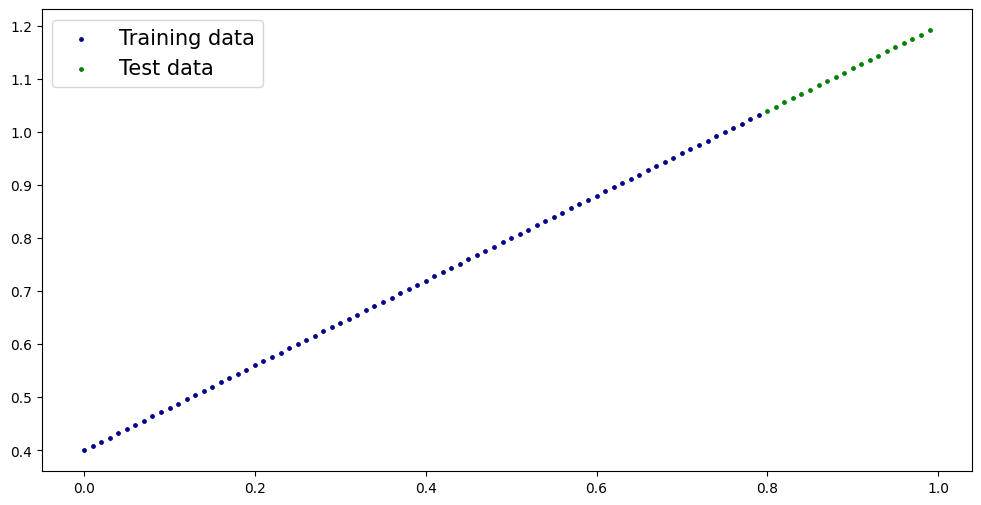

In [ ]:
plot_predictions()

Good, we have the data, we can see it. Now we can start building our model.

## Model Building

In the plot above we can see blue and green dots. The former represent the training data, the latter represent the test data. What we want to do is predict the test data. This means our predictions should be as close to the green dots as possible, ideally they should overlap, which is practically never the case, but they can be very, very close if the model works well. Speaking of which...

### Linear Regression Model with nn.Parameter

Models in PyTorch inherit from `nn.Module`. In the `__init__` method, we have to initialize our parameters. We can do it by explicitly setting them with `nn.Parameter` or we can create a linear layer of a neural network. Let's start by setting the parameters explicitly and we'll use the other solution later on to see how it compares. In any case, the parameters will be initialized with random values.

We also set the `requires_grad` argument to `True`. This way, the parameters will be updated with gradient descent in each iteration of the training loop so that they can change towards the values in the test set. As you remember, the idea here is to make the predictions as close to the true labels in the test set as possible.

Also, when we create a class that inherits from `nn.Module`, we have to overwrite the `forward` method. This method takes the features as an input (training or test features, depending on whether we're inside the training loop or the evaluation loop) and returns the predictions according to the linear regression formula we explained earlier. Here's the model class:

In [ ]:
# The class must inherit from nn.Module
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        # The parameters are initialized with random values and requires_grad set to True.
        self.weights = nn.Parameter(torch.randn(1), requires_grad=True)
        self.bias = nn.Parameter(torch.randn(1), requires_grad=True)

    # We must overwrite the forward method that will perform the model's computation.
    # The input is a tensor and so is the value returned by the method, so let's add the type annotations.
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias

Now that we have our class defined, let's create an instance of it and check out the random values of the parameters. For reproducibility's sake, let's set a seed for the random data to be identical each time a model is instantiated:

In [ ]:
# Let's set the seed to make the random data reproducible. You can use any number here, but 42 is often used.
torch.manual_seed(42)

# Let's instantiate our model.
model_0 = LinearRegressionModel()

# Let's check out the parameters.
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

As we can see, the random values of the two parameters are not even close to the values we set them to (0.8 and 0.4 respectively). We can also view the parameters as an ordered dictionary. To this end, we call the `state_dict` method. It returns all the parameters along with their values. We only have two parameters, but in more complex models there may be tens, thousands or even millions of them:

In [ ]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making Predictions

We know that the random parameters are very different from the values we set, so we shouldn't expect the predictions to be good. Let's check it out.

For predictions (also known as inference), we don't need the gradient tracking and a couple other things. To turn these features off, we use the `torch.inference_mode` as a context manager.

When we pass data to our model, it will be passed to the `forward` method and the predictions will be returned. We have to pass the test data and then we'll be able to compare the predictions with the test labels. Let's not be very optimictic, though:

In [ ]:
# Let's turn on inference mode and make the predictions.
with torch.inference_mode():
    y_preds = model_0(X_test)

And now we can compare the predictions with the test values:

In [ ]:
# Let's create a function using a pandas DataFrame to print the test values and the predictions side by side.
def view_test_vs_predictions(y_test, y_preds):
    test_vs_predictions = pd.DataFrame(zip(y_test, y_preds, y_test - y_preds), columns=['[y_test]', '[y_preds]', '[y_test - y_preds]'])
    print(test_vs_predictions.to_string(index=False))

We should see three columns. In the first column, we'll have the test values. In the second column, we'll have the predictions. In the third column, we'll have the differences between the former and the latter. We're going to need the differences to calculate the loss later on:

In [ ]:
view_test_vs_predictions(y_test, y_preds)

        [y_test]        [y_preds] [y_test - y_preds]
[tensor(1.0400)] [tensor(0.3982)]   [tensor(0.6418)]
[tensor(1.0480)] [tensor(0.4015)]   [tensor(0.6465)]
[tensor(1.0560)] [tensor(0.4049)]   [tensor(0.6511)]
[tensor(1.0640)] [tensor(0.4083)]   [tensor(0.6557)]
[tensor(1.0720)] [tensor(0.4116)]   [tensor(0.6604)]
[tensor(1.0800)] [tensor(0.4150)]   [tensor(0.6650)]
[tensor(1.0880)] [tensor(0.4184)]   [tensor(0.6696)]
[tensor(1.0960)] [tensor(0.4217)]   [tensor(0.6743)]
[tensor(1.1040)] [tensor(0.4251)]   [tensor(0.6789)]
[tensor(1.1120)] [tensor(0.4285)]   [tensor(0.6835)]
[tensor(1.1200)] [tensor(0.4318)]   [tensor(0.6882)]
[tensor(1.1280)] [tensor(0.4352)]   [tensor(0.6928)]
[tensor(1.1360)] [tensor(0.4386)]   [tensor(0.6974)]
[tensor(1.1440)] [tensor(0.4419)]   [tensor(0.7021)]
[tensor(1.1520)] [tensor(0.4453)]   [tensor(0.7067)]
[tensor(1.1600)] [tensor(0.4487)]   [tensor(0.7113)]
[tensor(1.1680)] [tensor(0.4520)]   [tensor(0.7160)]
[tensor(1.1760)] [tensor(0.4554)]   [tensor(0.

As we see, they're different, which should be reflected on the plot:

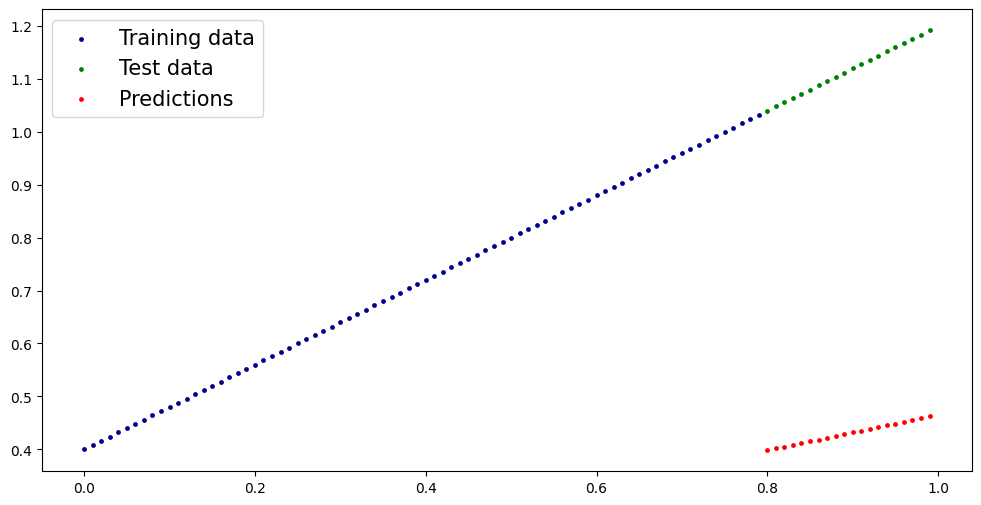

In [ ]:
plot_predictions(predictions=y_preds)

Just a reminder: The predictions (red dots) should ideally be on top of the test values (green dots). But are they?

The differences between the test values and the predictions are huge. So, let's train the model to make it predict better.

## Model Training

Training a model consists in continuous improvement of the parameters until they are very close to the target values, which are the values that will enable the predictions to be almost equal to the test values.

Why are the predictions so poor now? This is because of the random values, which means there's nothing smart involved, it's pure guessing. If we want the parameters to improve gradually in each iteration of the training loop, we have to pick a loss function and an optimizer.

### Loss Function and Optimizer

So, what is a loss function? It's a function that measures how wrong the model's predictions are. The lower its value the better. It's calculated by comparing the predictions to the truth labels, which are are the test labels.

There are many built-in loss functions in PyTorch. We're going to use a function called `nn.L1Loss` which is a fancy name for the MAE (mean absolute error) loss function, often used in regression. Just a quick reminder: The function calculates the mean distance between the predictions (red dots) and the test values (green dots). Smaller mean distance means the loss is smaller and predictions are better. But this is not the case here. Here, the loss is clearly significant and must be reduced.

As for the optimizer, it tells the model how to update the parameters in order to lower the loss. There are many optimization functions in `torch.optim`. We're going to use the Stochastic Gradient Descent (SGD) optimizer, which is very popular. The optimizer takes the model's parameters that it is supposed to optimize (weight and bias) as the first argument and learning rate as the second argument.

Learning rate is a number, usually pretty small, like 0.01, 0.001 or 0.0001, for example, that tells the optimizer how fast it should update the parameters. The higher the value, the faster the parameters will be updated, but if the value is too high, the minimum may be missed and the loss may start growing again. If the learning rate is too low, the optimizer will update the values too long.

So, let's define the loss function and the optimizer:

In [ ]:
# Define the MAE loss function.
loss_fn = nn.L1Loss()

# Define the SGD optimizer with the model's parameters (weight and bias) and learning rate (lr) equal to 0.01.
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

Next, we have to define the training loop and the testing loop.

### Training Loop and Testing Loop

The parameters are updated multiple times in a loop. In each iteration of the loop their values should get better. Iterating over the training data and updating the parameters is called the **training loop**.

Iterating over the test data, on the other hand, and evaluating the patterns learned on the training data, is called the **testing loop**.

Each loop consists of several steps. But before we list them here, we must decide how many times we want to loop. More iterations may mean better results because the model learns better. Each iteration is called an epoch. If we set the number of epochs to 100, there will be 100 iterations. If the results after the last epoch are not satisfactory, we can always train the model for more epochs and the training will then start where it left off. This means that training a model for 100 epochs and then for another 100 epochs will have the same result as training it for 200 epochs in the first place. So, let's start with 100 epochs and we'll see how much better the predictions get.

Also, we're going to store the epoch count, the train loss values and the test loss values as lists. We'll use them to track these values so that we can visualize them later.

So, what are the main stages of a training loop and testing loop? Let's start with the former.

The steps inside a training loop contain:

1. Forward pass - the model performs the `forward` method on all training data,
2. Loss calculation - the model's predictions are compared to the test values to see how badly the model performs,
3. Gradient zeroing - the optimizer's gradients are set to zero (by default, they're accumulated) so that they can be calculated from scratch for this step,
4. Backpropagation - the gradient of the loss with respect to each parameter with `requires_grad` set to `True` is calculated,
5. Gradient descent - the parameters are updated.

The testing loop consists of the following steps:

1. Forward pass - the model performs the `forward` method on all testing data,
2. Loss calculation - the model's predictions are compared to the test values to see how badly the model performs,
3. (optionally) Evaluation metrics - we can calculate metrics like accuracy, precision or recall on the test set; we're not going to do it here.

Now, let's implement all these steps in the training and testing loops.

In [ ]:
# seed for reprodicibility of random values
torch.manual_seed(42)

# Train for 100 epochs.
epochs = 100

# lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training loop

    # Put the model in training mode.
    model_0.train()

    # The stages as described in the text.

    # 1. Forward pass
    y_pred = model_0(X_train)

    # 2. Loss calculation
    loss = loss_fn(y_pred, y_train)

    # 3. Gradient zeroing
    optimizer.zero_grad()

    # 4. Backpropagation
    loss.backward()

    # 5. Gradient descent
    optimizer.step()

    ### Testing loop

    # Put the model in evaluation mode.
    model_0.eval()

    with torch.inference_mode():

        # The stages as described in the text.
        # 1. Forward pass
        test_pred = model_0(X_test)

        # 2. Loss calculation
        # Predictions are of the float data type and so must be the test labels in order to compare them.
        test_loss = loss_fn(test_pred, y_test.type(torch.float))

        # Add data to the lists and print information every tenth epoch
        if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | Train Loss (MAE): {loss} | Test Loss (MAE): {test_loss} ")

Epoch: 0 | Train Loss (MAE): 0.4541979432106018 | Test Loss (MAE): 0.6723175048828125 
Epoch: 10 | Train Loss (MAE): 0.33859533071517944 | Test Loss (MAE): 0.536965012550354 
Epoch: 20 | Train Loss (MAE): 0.2229928970336914 | Test Loss (MAE): 0.40161246061325073 
Epoch: 30 | Train Loss (MAE): 0.11255614459514618 | Test Loss (MAE): 0.27061301469802856 
Epoch: 40 | Train Loss (MAE): 0.06832710653543472 | Test Loss (MAE): 0.18864598870277405 
Epoch: 50 | Train Loss (MAE): 0.0569041483104229 | Test Loss (MAE): 0.14801186323165894 
Epoch: 60 | Train Loss (MAE): 0.052289120852947235 | Test Loss (MAE): 0.12742725014686584 
Epoch: 70 | Train Loss (MAE): 0.048731718212366104 | Test Loss (MAE): 0.11531449854373932 
Epoch: 80 | Train Loss (MAE): 0.045284587889909744 | Test Loss (MAE): 0.10629091411828995 
Epoch: 90 | Train Loss (MAE): 0.04185900092124939 | Test Loss (MAE): 0.09795530885457993 


As we see, the loss is lower in each epoch and it hasn't stopped falling down, which means, we could have used more epochs, which we will with the next model.

Anyway, let's use the lists we created to visualize the train loss and test loss:

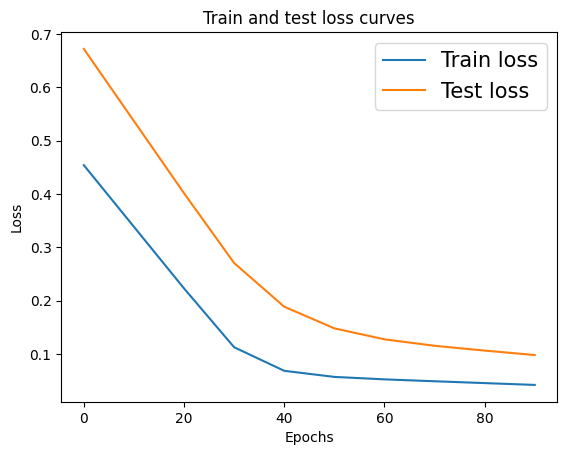

In [ ]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Train and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(prop={"size": 15})

We clearly see the loss is going down with each epoch, which is good. It means the parameters are updated correctly. Let's compare their original and current updated values:

In [ ]:
updated_weight = model_0.state_dict()['weights'].item()
updated_bias = model_0.state_dict()['bias'].item()

parameter_values = pd.DataFrame({'weight': [weight, updated_weight], 'bias': [bias, updated_bias]}, index=['target', 'updated'])
parameter_values.T

,target,updated
weight,0.8,0.608617
bias,0.4,0.480559


If you remember, the random values of the parameters were very far from the values we originally set (0.8 and 0.4 respectively). They were:

`OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])`

Now, after 100 epochs of training they're 0.608 and 0.481 respectively, which is much closer to the target values we set. This means the training was successful, although it doesn't mean we can't do better.

Let's evaluate the model now.

## Model Evaluation

We have a trained model, so let's see how well it performs. To evaluate a model, we have to set it in evaluation mode and make the predictions using the `torch.inference_mode` context manager:

In [ ]:
# 1. Set the model in evaluation mode.
model_0.eval()

# 2. Make predictions using the inference mode context manager.
with torch.inference_mode():
  y_preds = model_0(X_test)
y_preds

tensor([[0.9675],
        [0.9735],
        [0.9796],
        [0.9857],
        [0.9918],
        [0.9979],
        [1.0040],
        [1.0101],
        [1.0161],
        [1.0222],
        [1.0283],
        [1.0344],
        [1.0405],
        [1.0466],
        [1.0527],
        [1.0587],
        [1.0648],
        [1.0709],
        [1.0770],
        [1.0831]])

Just like before, let's visualize the results:

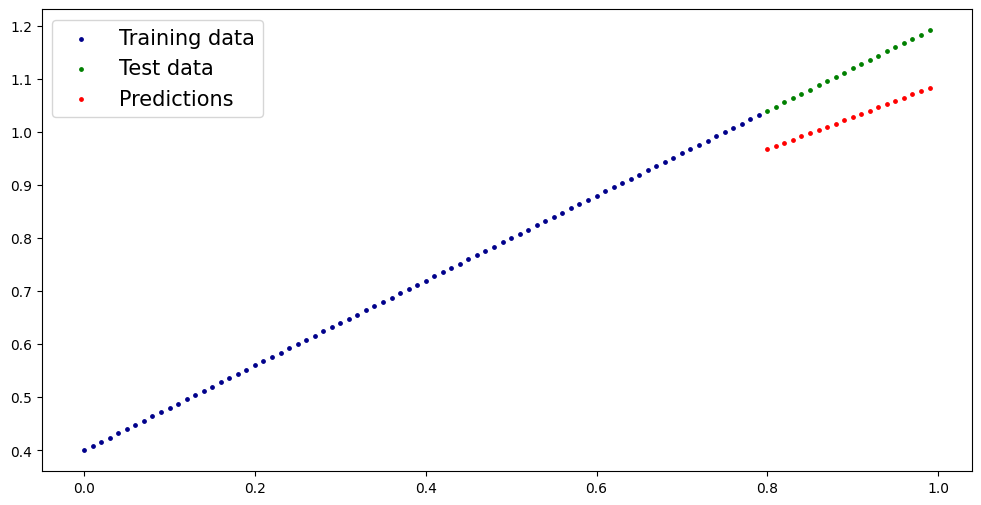

In [ ]:
plot_predictions(predictions=y_preds)

Great, the predictions (red dots) are much closer to the true values (green dots) than before. This means the model performs much better than when the parameters were set to random values. But there's still room for improvement. Let's train the model for another 100 epochs:

In [ ]:
torch.manual_seed(42)
epochs = 100
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    model_0.train()
    y_pred = model_0(X_train)
    loss = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_0.eval()
    with torch.inference_mode():
        test_pred = model_0(X_test)
        test_loss = loss_fn(test_pred, y_test.type(torch.float))
        if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | Train Loss (MAE): {loss} | Test Loss (MAE): {test_loss} ")

Epoch: 0 | Train Loss (MAE): 0.03843348100781441 | Test Loss (MAE): 0.08996371924877167 
Epoch: 10 | Train Loss (MAE): 0.03500743955373764 | Test Loss (MAE): 0.08197212964296341 
Epoch: 20 | Train Loss (MAE): 0.0315818190574646 | Test Loss (MAE): 0.0736365094780922 
Epoch: 30 | Train Loss (MAE): 0.028156336396932602 | Test Loss (MAE): 0.06564490497112274 
Epoch: 40 | Train Loss (MAE): 0.024730294942855835 | Test Loss (MAE): 0.057653315365314484 
Epoch: 50 | Train Loss (MAE): 0.02130463346838951 | Test Loss (MAE): 0.049317698925733566 
Epoch: 60 | Train Loss (MAE): 0.017879191786050797 | Test Loss (MAE): 0.041326116770505905 
Epoch: 70 | Train Loss (MAE): 0.01445315033197403 | Test Loss (MAE): 0.03333451598882675 
Epoch: 80 | Train Loss (MAE): 0.01102745346724987 | Test Loss (MAE): 0.024998921900987625 
Epoch: 90 | Train Loss (MAE): 0.0076020522974431515 | Test Loss (MAE): 0.017007315531373024 


The loss is even lower now, after the 200 epochs altogether. Let's visualize it again:

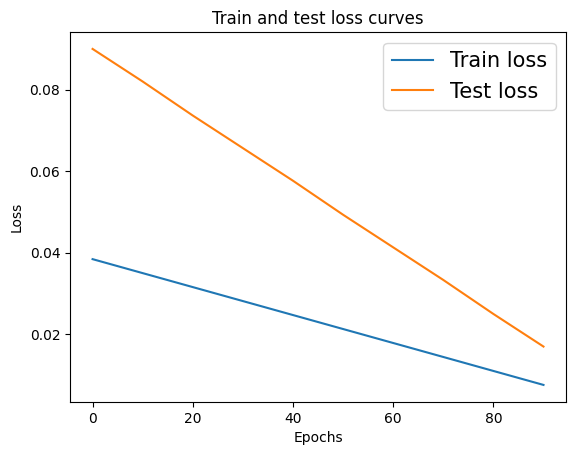

In [ ]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Train and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(prop={"size": 15})

As we can see, the loss was dropping linearly between the 100th and 200th epochs.

Let's check out the parameters again:

In [ ]:
updated_weight = model_0.state_dict()['weights'].item()
updated_bias = model_0.state_dict()['bias'].item()

parameter_values = pd.DataFrame({'weight': [weight, updated_weight], 'bias': [bias, updated_bias]}, index=['target', 'updated'])
parameter_values.T

,target,updated
weight,0.8,0.779230
bias,0.4,0.408809


The updated values are much closer to the target values. Let's evaluate the model again:

In [ ]:
model_0.eval()

with torch.inference_mode():
  y_preds = model_0(X_test)
y_preds

tensor([[1.0322],
        [1.0400],
        [1.0478],
        [1.0556],
        [1.0634],
        [1.0712],
        [1.0789],
        [1.0867],
        [1.0945],
        [1.1023],
        [1.1101],
        [1.1179],
        [1.1257],
        [1.1335],
        [1.1413],
        [1.1491],
        [1.1569],
        [1.1647],
        [1.1725],
        [1.1802]])

And let's visualize the results too:

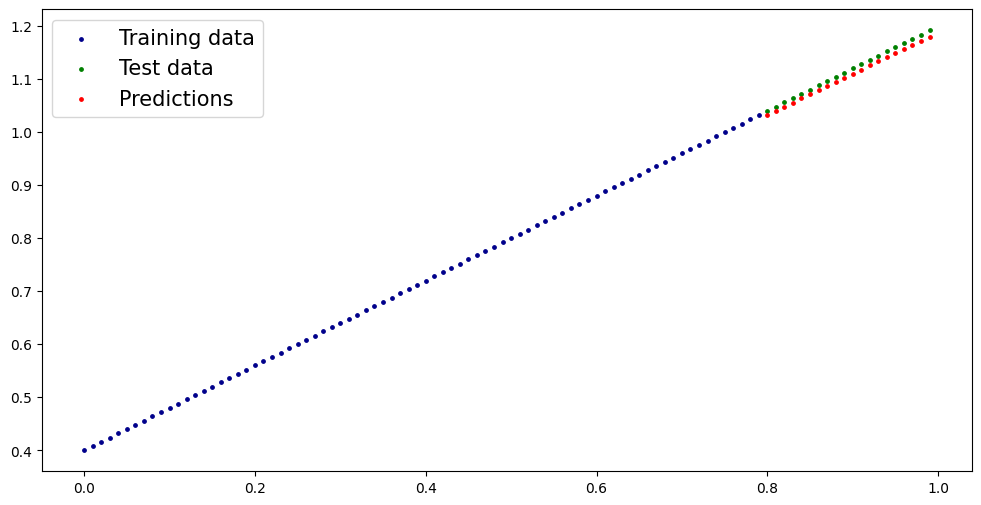

In [ ]:
plot_predictions(predictions=y_preds)

Now, the predictions are even closer. So, training the model for another 100 epochs was a good decision. We would have gotten the same results if we had trained the model for 200 epochs in the first place.

So, we have a pretty good model. Let's save it so that we don't have to repeat all the steps the next time we need the model. Here, with our tiny dataset, it wouldn't be a big problem, but larger datasets take much longer to train the model.

## Saving and Loading the Model

We have our parameters calculated, they seem pretty good, so it would be a good idea to save them somehow. We can save either the entire model or just the parameter dictionary. The recommended way for saving and loading models is by saving just the `state_dict`, and this is what are going to do here.

In general, there are three methods that we use to save and load models. These are:

- `torch.save` - used to save a pickled (serialized using the `pickle` tool) object to disk; the object may be a model, a tensor, a dictionary, etc.,
- `torch.load` - used to deserialize a pickled object,
- `torch.nn.Module.load_state_dict` - used to load a model's parameter dictionary (`state_dict`).

### Saving the Parameter Dictionary

We'll create a folder called models to store our models and save the model there:

In [ ]:
from pathlib import Path

# 1. Create the models folder.
MODELS_FOLDER = Path("models")
MODELS_FOLDER.mkdir(parents=True, exist_ok=True)

# 2. Create the model's save path.
MODEL_NAME = "linear_legression_model_0.pth"
MODEL_SAVE_PATH = MODELS_FOLDER / MODEL_NAME

# 3. Save the model's parameter dictionary
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/linear_legression_model_0.pth


If you now open the Files tab in Colab, you will see the new folder and the file in it:

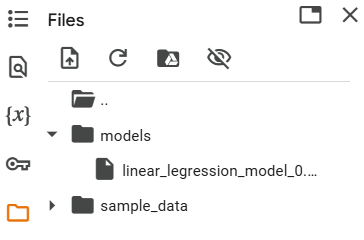

The parameter dictionary is saved. We can now create a new model instance and instantiate it with the data saved in the dictionary.

### Loading the Parameter Dictionary

We only saved the parameter dictionary, not the entire model, so we have to load it and pass it to the new instance of the model:

In [ ]:
# Create a new instance of the model.
model_1 = LinearRegressionModel()

# Load the parameter dictionary and pass it to the new instance of the model.
model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<ipython-input-39-a2658a505f3d>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


<All keys matched successfully>

Looks like it worked. But why not check it out? The new instance of the model, `model_1`, has now the same parameter values:

In [ ]:
model_1.eval()

with torch.inference_mode():
    model_1_preds = model_1(X_test)

Now we can compare the previous predictions with the predictions of the new model instance. The two model instances use the same values for weight and bias, so the predictions should be identical:

In [ ]:
y_preds == model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

And so they are. This means that our model (or rather its parameter dictionary) was saved and loaded correctly.

We're done. We have a working model, saved to the disk. We can use it in another notebook or in an application.

To recapitulate, though, in a more concise way, we'll follow all the steps again to create yet another instance of the model, with some minor changes this time in order to demonstrate how to create a model without explicitly specifying the parameters and creating a simple neural network instead.

## Recreating the Model Using a Simple Neural Network

To practice the typical workflow for linear regression models with PyTorch, let's recreate all the steps in a more concise manner, so without all those verbose comments, and with some minor changes here and there.

### Data Preparation

So, just like before, we start with the imports:

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd

Now, here's the first minor change. Let's make the code device-agnostic, so if a GPU is available, it will be used, otherwise the CPU will be used:

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Currently used device: {device}')

Currently used device: cpu


As you can see, the CPU is used. Let's change it to GPU. It's possible if we use Colab. In the Runtime menu, we select Change runtime type and pick a GPU:

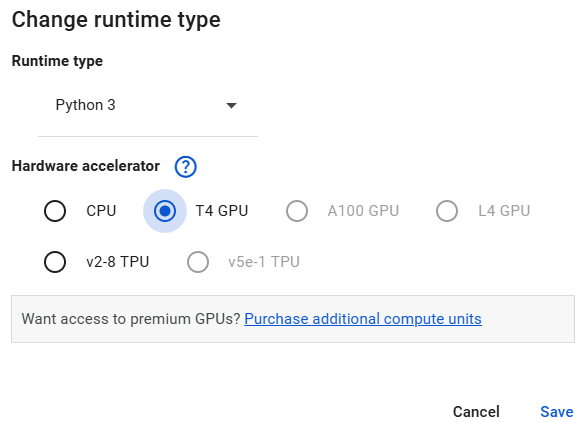

This will restart the Colab runtime and we'll lose all the saved variables. As we're starting the recreation of the model from scratch, we don't have to run all the preceding cells again. We only have to run the cell with the imports we just added. Let's check the current device again:

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Currently used device: {device}')

Currently used device: cuda


Now we're using cuda, which means GPU.

Let's recreate all the initial steps now:

In [3]:
weight = 0.8
bias = 0.4

start = 0
end = 1
step = 0.01

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:5], y[:5]

(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.4000],
         [0.4080],
         [0.4160],
         [0.4240],
         [0.4320]]))

Let's create the training and test sets:

In [4]:
split_level = int(0.8 * len(X))

X_train, y_train = X[:split_level], y[:split_level]
X_test, y_test = X[split_level:], y[split_level:]

len(X_train), len(y_train), len(X_test), len(y_test)

(80, 80, 20, 20)

Let's visualize the data (make sure to run the cell above where the `plot_predictions` function was defined because we lost it while switching the runtime):

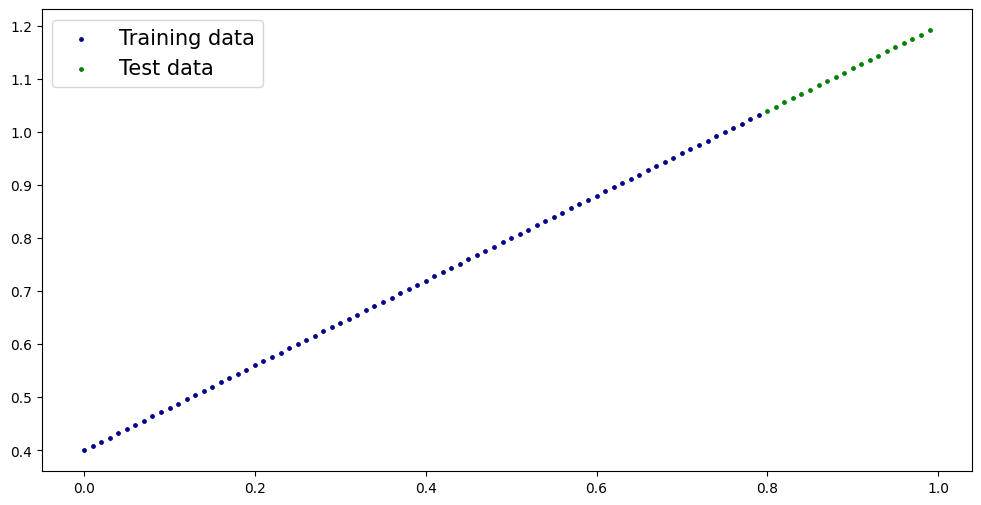

In [7]:
plot_predictions(X_train, y_train, X_test, y_test)

### Model Building

Let's build the model now. Here's the second change I'd like to introduce. Previously, we defined the weight and bias parameters using `nn.Parameter`. This time, we'll use `nn.Linear` to build a simple neural network with a linear layer. The `nn.Linear` method takes `in_features` and `out_features` as parameters:

`in_features` - the number of dimensions of the input data,
`out_features` - the number of dimensions the data should be output to.

We'll set both `in_features` and `out_features` to 1 because our data has one input feature (`X`) per label (`y`):

In [8]:
# Let's define a new model class.
class LinearRegressionModelNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1, out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

Now, let's create an instance of the model class:

In [9]:
torch.manual_seed(42)
model_2 = LinearRegressionModelNN()
model_2, model_2.state_dict()

(LinearRegressionModelNN(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

As we can see, the parameters (weight and bias) are set randomly again.

Let's check whether the new model is on GPU or CPU:

In [10]:
next(model_2.parameters()).device

device(type='cpu')

Turns out, it's on CPU. Let's put it on GPU if it's available. To do this, we have to call the `to` method and pass the device to it. We set the device before to be GPU (cuda) if available or CPU otherwise, so, if GPU is not available, it will stay on CPU anyway:

In [11]:
model_2.to(device)

# Let's check the model's current device again.
next(model_2.parameters()).device

device(type='cuda', index=0)

Good. Now the model is on the GPU. It's time to train the model.

### Model Training

We can now create the loss function and optimizer and train our model. There's nothing new here, maybe just one thing - we'll set the number of epochs to 500. With the first model we saw that at 200 epochs the predictions were pretty good, but still they did not sit on top of the green dots. Maybe we could do just a teeny tiny little bit better by increasing the number of epochs some. Why not check it out?

And one more thing. For this to work, we have to put the data sets on the available device, just like we did with the model.

In [12]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.01)
torch.manual_seed(42)
epochs = 500

# We must put the data on the available device.
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    model_2.train()
    y_pred = model_2(X_train)
    loss = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_2.eval()
    with torch.inference_mode():
        test_pred = model_2(X_test)
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 50 == 0:
        print(f"Epoch: {epoch} | Train Loss (MAE): {loss} | Test Loss (MAE): {test_loss} ")

Epoch: 0 | Train Loss (MAE): 0.4160006642341614 | Test Loss (MAE): 0.3847346305847168 
Epoch: 50 | Train Loss (MAE): 0.029736531898379326 | Test Loss (MAE): 0.06812500208616257 
Epoch: 100 | Train Loss (MAE): 0.012602212838828564 | Test Loss (MAE): 0.02885502576828003 
Epoch: 150 | Train Loss (MAE): 0.0029572814237326384 | Test Loss (MAE): 0.012540793977677822 
Epoch: 200 | Train Loss (MAE): 0.0029572814237326384 | Test Loss (MAE): 0.012540793977677822 
Epoch: 250 | Train Loss (MAE): 0.0029572814237326384 | Test Loss (MAE): 0.012540793977677822 
Epoch: 300 | Train Loss (MAE): 0.0029572814237326384 | Test Loss (MAE): 0.012540793977677822 
Epoch: 350 | Train Loss (MAE): 0.0029572814237326384 | Test Loss (MAE): 0.012540793977677822 
Epoch: 400 | Train Loss (MAE): 0.0029572814237326384 | Test Loss (MAE): 0.012540793977677822 
Epoch: 450 | Train Loss (MAE): 0.0029572814237326384 | Test Loss (MAE): 0.012540793977677822 


Good, looks like the loss is pretty low:

In [13]:
updated_weight = model_2.state_dict()['linear_layer.weight'].item()
updated_bias = model_2.state_dict()['linear_layer.bias'].item()

parameter_values = pd.DataFrame({'weight': [weight, updated_weight], 'bias': [bias, updated_bias]}, index=['target', 'updated'])
parameter_values.T

,target,updated
weight,0.8,0.796074
bias,0.4,0.404508


Great, the values seem very close. Let's make the predictions and visualize the data with the predictions.

### Model Evaluation

Let's evaluate the model then:

In [14]:
model_2.eval()
with torch.inference_mode():
    y_preds = model_2(X_test)
y_preds

tensor([[1.0414],
        [1.0493],
        [1.0573],
        [1.0652],
        [1.0732],
        [1.0812],
        [1.0891],
        [1.0971],
        [1.1051],
        [1.1130],
        [1.1210],
        [1.1289],
        [1.1369],
        [1.1449],
        [1.1528],
        [1.1608],
        [1.1687],
        [1.1767],
        [1.1847],
        [1.1926]], device='cuda:0')

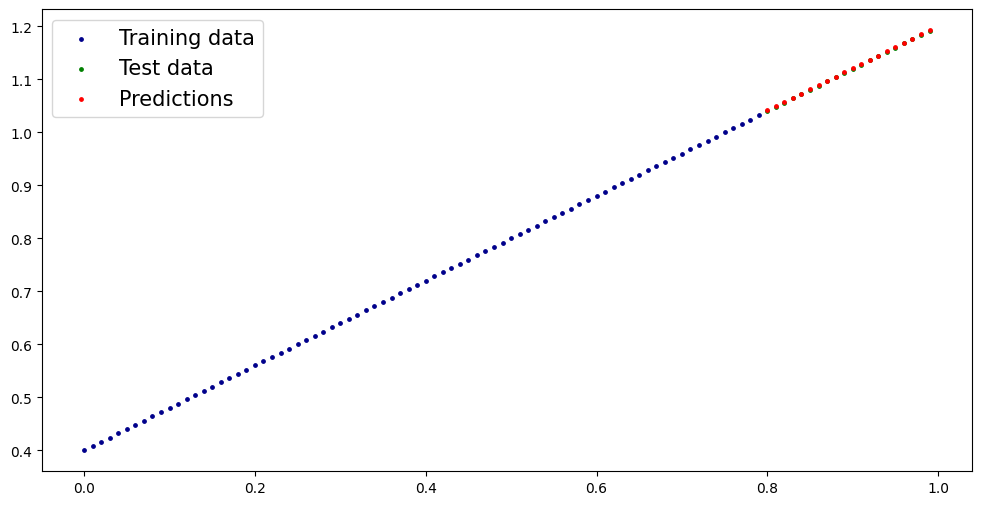

In [15]:
plot_predictions(predictions=y_preds.cpu())

As you can see, the red dots sit almost exactly on top of the green ones, which means the model is performing really well.

## Conclusion

We trained a pretty good model. Its predictions are very good. It's been a very basic model, but I just wanted to show you all the necessary steps it takes to create a complete linear regression model.

If you want, you can save the model and use it later in another notebook or application. I'm not going to repeat those steps here, but you know how to do it.